In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pickle
from tqdm.notebook import tqdm
import splitfolders
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [5]:
# zipfile 해제
with zipfile.ZipFile(base_path + 'corneal.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [6]:
# train, valid, test 데이터 분리(8:1:1)
splitfolders.ratio('/content/corneal', output = 'corneal_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 9600 files [00:01, 6661.58 files/s]


# Zero-Centering

In [7]:
train_path = '/content/corneal_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [8]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [9]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

# Data Loader

In [10]:
batch_size = 128

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)

In [12]:
train_generator = train_datagen.flow_from_directory('/content/corneal_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/corneal_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/corneal_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 7680 images belonging to 2 classes.
Found 960 images belonging to 2 classes.
Found 960 images belonging to 2 classes.


# Model

In [13]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50_zero = tf.keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 5s 0us/step


In [15]:
# tensorboard log 저장
model_name = 'corneal_ZeroCentering'
current_time = datetime.datetime.now().strftime("%m%d%H%M") # Y : 연도 / m : 월 / d : 일 / H : 시 / M : 분 / S : 초
current_time

'03270558'

In [14]:
# model compile
s_model_res50_zero.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [17]:
# model train

log_dir = "/content/drive/MyDrive/image_recognition/ayun/logs/ZeroCentering/" + current_time + model_name
board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # epoch마다 히스토그램 계산
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True) # EarlyStooping , restore_best_weights = True 가장 성능이 좋았을때 

history = s_model_res50_zero.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks=[board, early]) # 콜백 전달

Epoch 1/100
60/60 [==============================] - 53s 607ms/step - loss: 1.8790 - accuracy: 0.8898 - recall: 0.9029 - val_loss: 0.0196 - val_accuracy: 0.9937 - val_recall: 0.9896
Epoch 2/100
60/60 [==============================] - 30s 500ms/step - loss: 0.0253 - accuracy: 0.9930 - recall: 0.9927 - val_loss: 0.0191 - val_accuracy: 0.9969 - val_recall: 1.0000
Epoch 3/100
60/60 [==============================] - 35s 582ms/step - loss: 0.2786 - accuracy: 0.9681 - recall: 0.9672 - val_loss: 0.0287 - val_accuracy: 0.9937 - val_recall: 0.9937
Epoch 4/100
60/60 [==============================] - 30s 488ms/step - loss: 0.0367 - accuracy: 0.9913 - recall: 0.9870 - val_loss: 0.0273 - val_accuracy: 0.9958 - val_recall: 1.0000
Epoch 5/100
60/60 [==============================] - 35s 586ms/step - loss: 0.0093 - accuracy: 0.9958 - recall: 0.9932 - val_loss: 0.0059 - val_accuracy: 0.9969 - val_recall: 0.9958
Epoch 6/100
60/60 [==============================] - 30s 492ms/step - loss: 0.0068 - accur

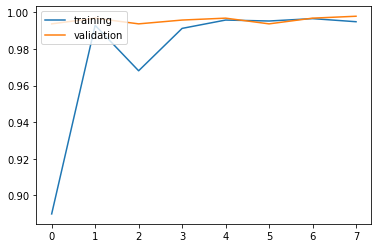

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [18]:
# model eavl
s_model_res50_zero.evaluate(test_generator)

8/8 [==============================] - 3s 380ms/step - loss: 0.0154 - accuracy: 0.9937 - recall: 0.9937


[0.015419723466038704, 0.9937499761581421, 0.9937499761581421]

In [19]:
# 모델 저장 경로 및 파일명 지정
model_path = '/content/drive/MyDrive/image_recognition/js/model/corneal_zero.h5'

# 모델 저장
s_model_res50_zero.save(model_path)

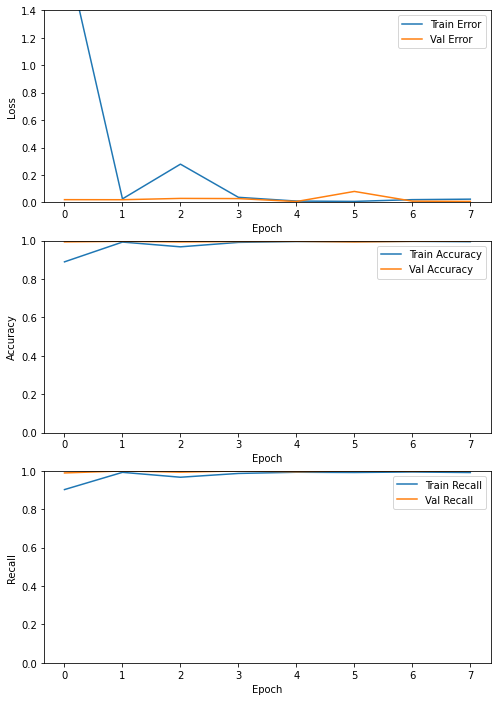

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# loss, accuracy, recall check
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)